In [2]:
import argparse
import os
import random
import json
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchshow as ts
from timechat.common.config import Config
from timechat.common.dist_utils import get_rank
from timechat.common.registry import registry
from timechat.conversation.conversation_video import Chat, Conversation, default_conversation,SeparatorStyle, conv_llava_llama_2
import decord
import cv2
import time
import subprocess
from decord import VideoReader
from timechat.processors.video_processor import ToTHWC, ToUint8, load_video
decord.bridge.set_bridge('torch')

# imports modules for registration
from timechat.datasets.builders import *
from timechat.models import *
from timechat.processors import *
from timechat.runners import *
from timechat.tasks import *

import random as rnd
from transformers import StoppingCriteria, StoppingCriteriaList
from PIL import Image
import gradio as gr

Matplotlib is building the font cache; this may take a moment.


In [3]:
def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", default='eval_configs/timechat.yaml', help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=0, help="specify the gpu to load the model.")
    parser.add_argument("--num-beams", type=int, default=1)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--text-query", default="What is he doing?", help="question the video")
    parser.add_argument("--video-path", default='examples/hotdog.mp4', help="path to video file.")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(args=[])
    return args

In [5]:
print('Initializing Chat')
args = parse_args()
cfg = Config(args)

DIR="ckpt/timechat"
MODEL_DIR=f"{DIR}/timechat_7b.pth"

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_config.ckpt = MODEL_DIR
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))
model.eval()

vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

Initializing Chat
Loading VIT


INFO:root:freeze vision encoder


Loading VIT Done
Loading Q-Former
use text input for Qformer


INFO:root:load checkpoint from /home/v-shuhuairen/mycontainer/ckpt/instruct-blip/instruct_blip_vicuna7b_trimmed.pth
INFO:root:freeze Qformer
INFO:root:Loading Q-Former Done
INFO:root:Loading LLAMA Tokenizer
Using pad_token, but it is not set yet.
INFO:root:Loading LLAMA Model
Loading checkpoint shards: 100%|██████████| 2/2 [01:05<00:00, 32.90s/it]
INFO:root:use gradient checkpointing for LLAMA
INFO:root:Loading LLAMA Done
INFO:root:Using LORA
INFO:root:Loading LLAMA proj
INFO:root:LLAMA proj is frozen
INFO:root:Loading llama_proj Done


trainable params: 0 || all params: 6,771,970,048 || trainable%: 0.0


INFO:root:video_Qformer is frozen


Load first Checkpoint: /home/v-shuhuairen/mycontainer/ckpt/TimeChat-7b/timechat_7b.pth


In [6]:
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

Initialization Finished


torch.Size([3, 32, 224, 398])


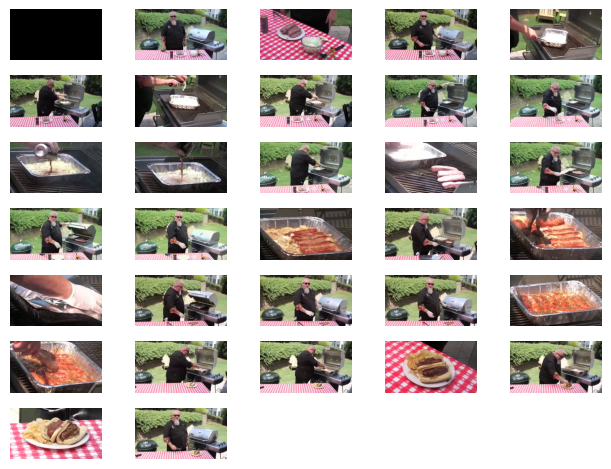

In [11]:
video, _ = load_video(
    video_path=args.video_path,
    n_frms=32,
    sampling ="uniform", return_msg = True
)
# video = vis_processor.transform(video)
print(video.size())
C, T, H, W = video.shape
ts.show(video.transpose(0, 1))

In [12]:
img_list = []
chat_state = conv_llava_llama_2.copy()
chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully and explain your answers in detail."
msg = chat.upload_video_without_audio(
    video_path=args.video_path, 
    conv=chat_state,
    img_list=img_list, 
    n_frms=96,
)

In [13]:
text_input = "You are given a cooking video from the YouCook2 dataset. Please watch the video and extract a maximum of 10 significant cooking steps. For each step, determine the starting and ending times and provide a concise description. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'."
print(text_input)

chat.ask(text_input, chat_state)

num_beams = args.num_beams
temperature = args.temperature
llm_message = chat.answer(conv=chat_state,
                          img_list=img_list,
                          num_beams=num_beams,
                          temperature=temperature,
                          max_new_tokens=300,
                          max_length=2000)[0]

print(llm_message)

You are given a cooking video from the YouCook2 dataset. Please watch the video and extract a maximum of 10 significant cooking steps. For each step, determine the starting and ending times and provide a concise description. The format should be: 'start time - end time, brief step description'. For example, ' 90 - 102 seconds, spread margarine on two slices of white bread'.
0.0 - 7.9 seconds, A man in a red apron is standing in a backyard.  8.9 - 20.0 seconds, He has a grill.  20.0 - 41.8 seconds, He is cooking something in a cast iron skillet.  41.8 - 49.3 seconds, There are some sliced hot dogs in the pan.  49.3 - 77.3 seconds, He is pouring something into the pan.  77.3 - 81.7 seconds, He is putting some of the sliced hot dogs in the pan.  81.7 - 110.2 seconds, He is putting more sauce and some peppers into the pan.  110.2 - 118.7 seconds, He is pouring sauce over the sliced hot dogs.  118.7 - 147.0 seconds, He is adding some sliced hot dogs.  147.0 - 186.5 seconds, He is grilling t